In [1]:
#Automated reloading of custom modules
%load_ext autoreload
%autoreload 2

#Standard modules
import os
import time
import random

import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime

#Custom modules
import helpers as hlp
import models as mdl

#!nvidia-smi

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### GPU and Reproductability

In [2]:
# Check avaibale device
DEVICE = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(DEVICE))
torch.cuda.empty_cache()

# Reproductilility
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Device: cuda:7


### Parameters

In [3]:
#Dataset
DATASET = "CIFAR10" 
MODEL = "ResNet9"
REDUCED = 0.1
FEATURE_DIM = 100
FED_CLASSIFIER = False

#Collaborative learning
N_CLIENTS = 10
SIZES = None # None for uniform sizes or array of length N_CLIENTS using all the data
ALPHA = "uniform" #'uniform', 'disjoint' or postive.

#Learning
BATCH_SIZE = 64
ROUNDS = 100
EPOCHS_PER_ROUND = 1
LR=1e-3
LAMBDA = 1
CRITERION = nn.CrossEntropyLoss()
CRITERION_KD = nn.MSELoss()
CRITERION_DISC = nn.BCELoss()
N_EVAL = 1 #Evaluate train and test performace after N_EVAL epochs

#Directories
DATE = datetime.now()
EXPORT_DIR = "./saves/Experiments/" + DATE.strftime("%d-%m-%Y/%H-%M-%S")
#os.makedirs(EXPORT_DIR, exist_ok=True)

### Data loading

** Using CIFAR **
Load train data...
Files already downloaded and verified
Load validation data...
Files already downloaded and verified
Dataset sizes:
	- Train: (5000, 3, 32, 32) (61.48 MB)
	- Validation (1000, 3, 32, 32) (12.296 MB)


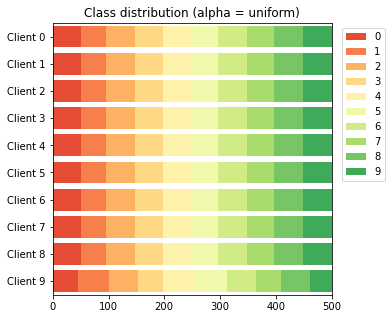

In [4]:
torch.cuda.memory_allocated(device=None)# Load dataset
train_input, train_target, val_input, val_target, meta = hlp.load_data(dataset=DATASET, reduced=REDUCED, device=DEVICE)

#Create custom torch datasets
train_ds = hlp.CustomDataset(train_input, train_target)
val_ds = hlp.CustomDataset(val_input, val_target)

#Split dataset
train_ds_list, val_ds_list = hlp.split_dataset(N_CLIENTS, train_ds, val_ds, ALPHA, SIZES)

#Create dataloader
train_dl_list = hlp.ds_to_dl(train_ds_list, batch_size=BATCH_SIZE)
val_dl_list = hlp.ds_to_dl(val_ds_list, batch_size=10*BATCH_SIZE)
global_val_dl = hlp.ds_to_dl(val_ds, batch_size=10*BATCH_SIZE)
global_train_dl = hlp.ds_to_dl(train_ds, batch_size=10*BATCH_SIZE)

#Visualize partition
hlp.visualize_class_dist(train_ds_list, meta["n_class"], title="Class distribution (alpha = {})".format(ALPHA),savepath=None)

# Store dataset sizes
meta["n_total"] = train_input.shape[0] 
meta["n_local"] = [ds.inputs.shape[0] for ds in train_ds_list]

## Traditional (spearated) learning

Round 100 done. (3.5s)          

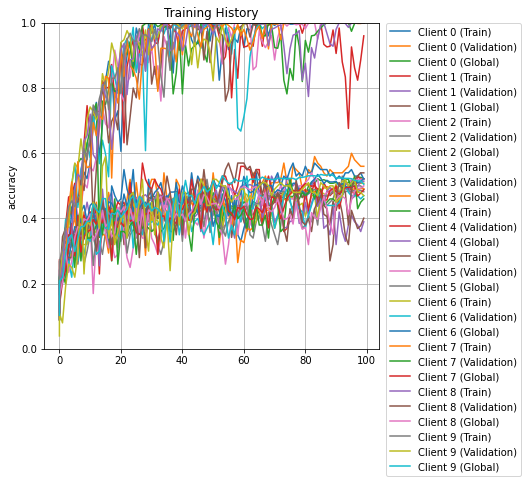

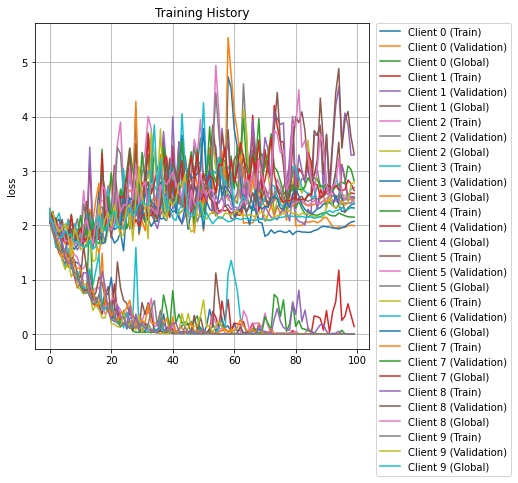

In [10]:
# Model initialization
client_models = [mdl.get_model(MODEL, FEATURE_DIM, meta).to(DEVICE) for _ in range(N_CLIENTS)]

# Performance tracker
perf_trackers = [hlp.PerfTracker(client_models[i], 
                                 {"Train": train_dl_list[i], "Validation": val_dl_list[i], "Global": global_val_dl}, 
                                 CRITERION, meta["n_class"], ID="Client {}".format(i)) for i in range(N_CLIENTS)]

# Optimizers
optimizers = [torch.optim.Adam(m.parameters(), lr=LR) for m in client_models]

# Feature tracker
feat_tracker = hlp.FeatureTracker(client_models, train_dl_list, FEATURE_DIM, meta)

#Each client updates its model independently on its own dataset
for r in range(ROUNDS):
    t0 = time.time()
    for client_id in range(N_CLIENTS):
        #Setting up the local training
        model = client_models[client_id]
        model.train()
        optimizer = optimizers[client_id]

        #Local update
        for e in range(EPOCHS_PER_ROUND):
            for inputs, target in train_dl_list[client_id]:
                optimizer.zero_grad()
                logits = model(inputs)
                loss = CRITERION(logits, target)
                loss.backward()
                optimizer.step()
        
        #Tracking performance
        if r % N_EVAL == 0:
            perf_trackers[client_id].new_eval(index=r)      
    
    # Compute representations
    feat_tracker.new_round()

    t1 = time.time()    
    print("\rRound {} done. ({:.1f}s)".format(r+1, t1-t0), end=10*" ") 
    

# Plot training history
hlp.plot_global_training_history(perf_trackers, metric="accuracy")
hlp.plot_global_training_history(perf_trackers, metric="loss")

### Learning with private KD

Round 100 done. (3.7s)          

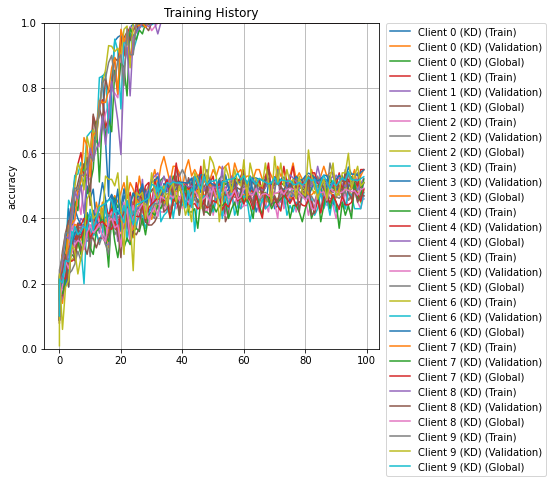

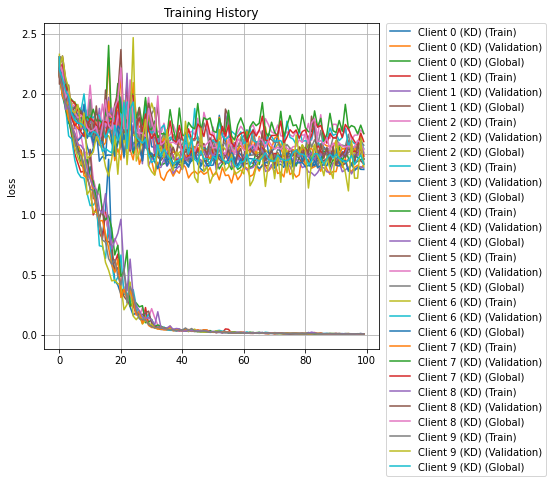

In [5]:
# Model initialization
client_models_kd = [mdl.get_model(MODEL, FEATURE_DIM, meta).to(DEVICE) for _ in range(N_CLIENTS)]

# Performance tracker
perf_trackers_kd = [hlp.PerfTracker(client_models_kd[i], {"Train": train_dl_list[i], "Validation": val_dl_list[i], "Global": global_val_dl}, 
                                    CRITERION, meta["n_class"], ID="Client {} (KD)".format(i)) for i in range(N_CLIENTS)]

# Optimizers
optimizers_kd = [torch.optim.Adam(m.parameters(), lr=LR) for m in client_models_kd]

# Feature tracker and discriminator
feat_tracker_kd = hlp.FeatureTracker(client_models_kd, train_dl_list, FEATURE_DIM, meta)
discriminators = [mdl.Discriminator("prob_product", client_models_kd[i].classifier) for i in range(N_CLIENTS)]

#Each client updates its model locally on its own dataset (Standard)
for r in range(ROUNDS):
    t0 = time.time()
    
    for client_id in range(N_CLIENTS):
        #Setting up the local training
        disc = discriminators[client_id]
        model = client_models_kd[client_id]
        model.train()
        optimizer = optimizers_kd[client_id]

        #Local update
        for e in range(EPOCHS_PER_ROUND):
            for inputs, targets in train_dl_list[client_id]:
                # Reset gradient
                optimizer.zero_grad()
                
                # Local representation
                features = model.features(inputs)
                logits = model.classifier(features)
                
                # Compute estimated probabilities
                features_global = feat_tracker_kd.get_global_features().to(DEVICE)
                targets_global = torch.arange(meta["n_class"]).to(DEVICE)
                scores, disc_targets = disc(features, features_global, targets, targets_global)
                
                # Optimization step
                if LAMBDA:
                    loss = CRITERION(logits, targets) + LAMBDA*(CRITERION_KD(features, features_global[targets]) + CRITERION_DISC(scores, disc_targets))
                else:
                    loss = CRITERION(logits, targets)
                loss.backward()
                optimizer.step()
                
        if FED_CLASSIFIER:
            # Aggregation (weighted average)
            global_classifier = mdl.get_model(MODEL, FEATURE_DIM, meta).to(DEVICE)
            global_parameters = global_classifier.classifier.state_dict()
            for k in global_parameters.keys():
                global_parameters[k] = torch.stack([(meta["n_local"][i] / meta["n_total"]) * client_models_kd[i].classifier.state_dict()[k] for i in range(N_CLIENTS)], 0).sum(0)
            
            for model in client_models_kd:
                model.classifier.load_state_dict(global_parameters)
        
        #Tracking performance
        if r % N_EVAL == 0:
            perf_trackers_kd[client_id].new_eval(index=r)      
            
    # Compute representations
    feat_tracker_kd.new_round()
    
    t1 = time.time()    
    print("\rRound {} done. ({:.1f}s)".format(r+1, t1-t0), end=10*" ")  

# Plot training history
hlp.plot_global_training_history(perf_trackers_kd, metric="accuracy")
hlp.plot_global_training_history(perf_trackers_kd, metric="loss")

### Convert to executable

In [7]:
# Convert to executable (without the Magic cells)
#!jupyter nbconvert \
#    --TagRemovePreprocessor.enabled=True \
#    --TagRemovePreprocessor.remove_cell_tags 'Magic' \
#    --TemplateExporter.exclude_markdown=True \
#    --to python "BlindLearning.ipynb"

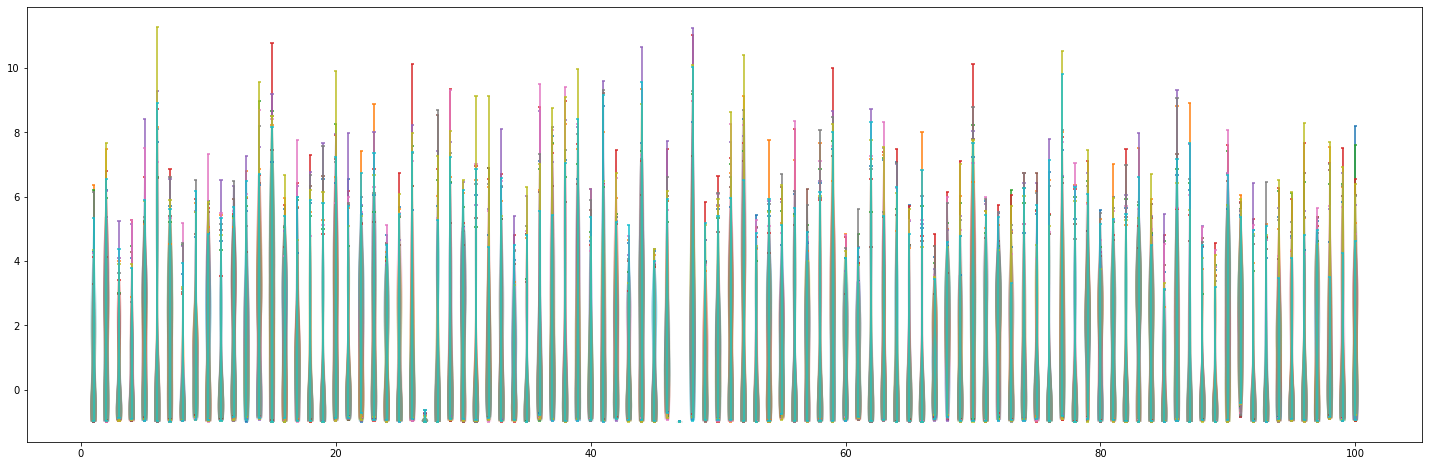

In [7]:
user = 1
r = -1
fig, ax = plt.subplots(1,1, figsize=(25,8))
with torch.no_grad():
    buffer = feat_tracker_kd.buffers[user][r]
    for c in range(10):
        plt.violinplot(buffer[train_ds_list[user].targets == c].transpose(0,1))

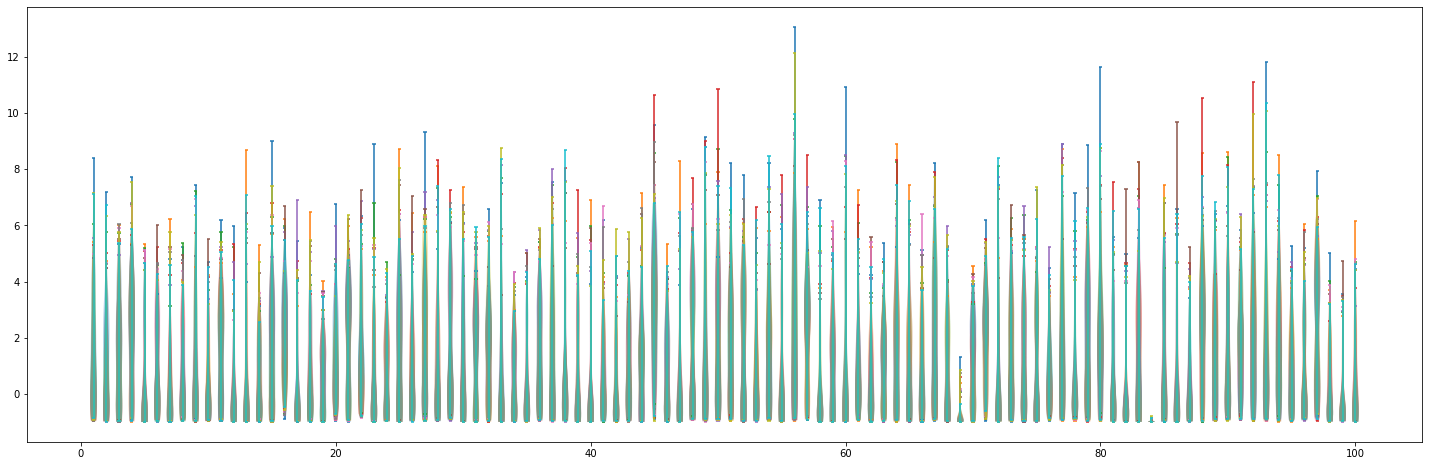

In [8]:
user = 0
r = -1
fig, ax = plt.subplots(1,1, figsize=(25,8))
with torch.no_grad():
    buffer = feat_tracker.buffers[user][r]
    for c in range(10):
        plt.violinplot(buffer[train_ds_list[user].targets == c].transpose(0,1))

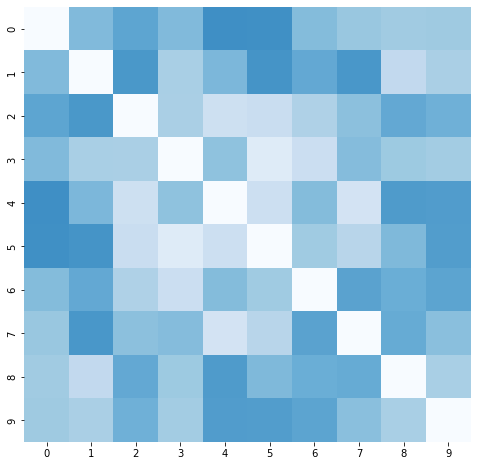

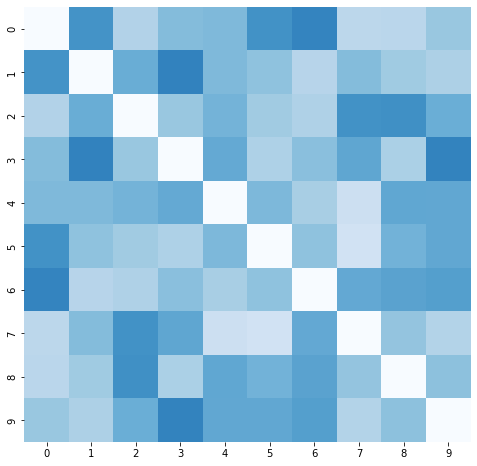

In [9]:
feat_tracker.plot_variance_heatmap()
feat_tracker_kd.plot_variance_heatmap()

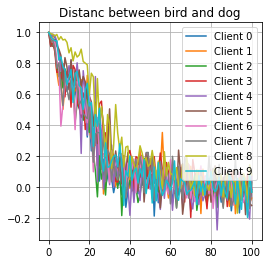

In [8]:
#feat_tracker.plot_class_distance(2,5)
feat_tracker_kd.plot_class_distance(2,5)

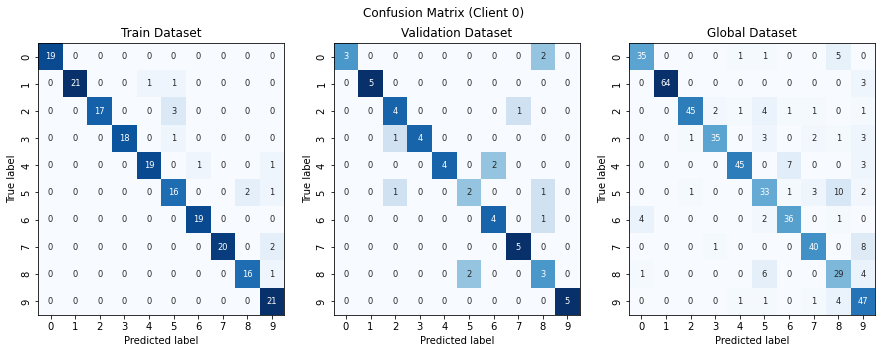

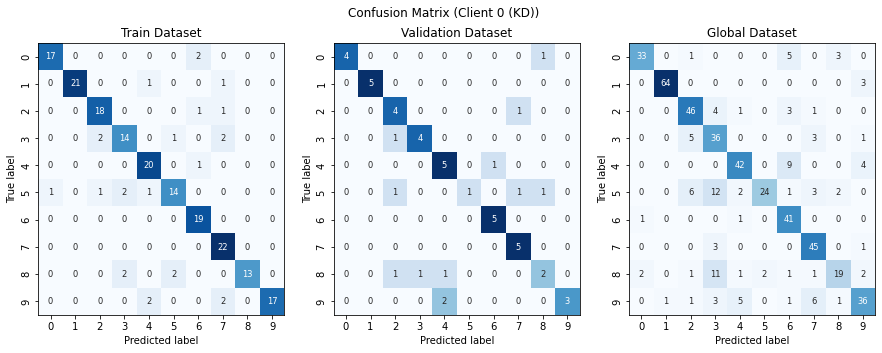

In [32]:
perf_trackers[0].plot_confusion_matrix()
perf_trackers_kd[0].plot_confusion_matrix()

In [34]:
a = torch.tensor([[1,1,1], [2,2,2]])
b = torch.tensor([[3,1,3], [0,0,2], [10,9,8]])
ans = (a.unsqueeze(1) * b.unsqueeze(0)).sum(-1).flatten()

In [17]:
torch.exp(a)

tensor([[2.7183, 2.7183, 2.7183],
        [7.3891, 7.3891, 7.3891]])

In [53]:
scores, disc_targets = disc(features, features_global, targets, targets_global)

In [36]:
for s, t in zip(scores, disc_targets):
    print(s.item(), t.item())

0.08433256298303604 0.0
0.08433256298303604 0.0
0.08433256298303604 0.0
0.08433256298303604 0.0
0.6265408396720886 0.0
0.005737071391195059 0.0
0.989642858505249 1.0
1.0095728839587537e-06 0.0
0.006435073912143707 0.0
0.08433256298303604 0.0
0.09410139918327332 0.0
0.09410139918327332 0.0
0.09410139918327332 0.0
0.09410139918327332 0.0
0.26134586334228516 0.0
0.23067575693130493 0.0
0.3620091378688812 1.0
0.09524919092655182 0.0
0.22350886464118958 0.0
0.09410139918327332 0.0
0.10474744439125061 0.0
0.10474744439125061 0.0
0.10474744439125061 0.0
0.10474744439125061 0.0
0.00012510200031101704 0.0
0.5641879439353943 0.0
0.00010569909500190988 0.0
0.0001544833939988166 0.0
0.4444446563720703 1.0
0.10474744439125061 0.0
0.10105682164430618 0.0
0.10105682164430618 0.0
0.10105682164430618 0.0
0.10105682164430618 0.0
0.0016590537270531058 0.0
0.4983562231063843 1.0
0.0025261910632252693 0.0
0.004306142684072256 0.0
0.49254053831100464 0.0
0.10105682164430618 0.0
0.10181915760040283 0.0
0.101

In [16]:
m = client_models_kd[0]
f = feat_tracker_kd.average_features[6][-1].to(DEVICE)
#f = feat_tracker_kd.get_global_features().to(DEVICE)
l = m.classifier(f)
p = F.softmax(l, dim=1).argmax(1)
p

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:7')

In [74]:
train_dl_list[0]

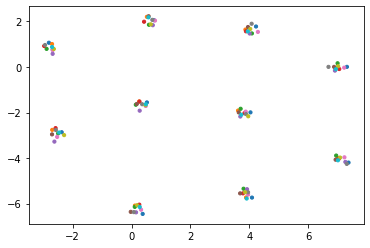

In [6]:
feat_tracker_kd.plot_tSNE()

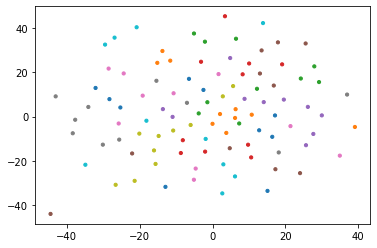

In [11]:
feat_tracker.plot_tSNE()

In [26]:
t = 0
for i in range(N_CLIENTS):
    t+=(hlp.evaluate_model(client_models[i], global_val_dl, CRITERION, meta["n_class"])["accuracy"] - hlp.evaluate_model(client_models_kd[i], global_val_dl, CRITERION, meta["n_class"])["accuracy"])
print(t)

-0.10699999999999998


In [23]:
global_train_dl = hlp.ds_to_dl(train_ds, batch_size=10*BATCH_SIZE)

In [27]:
N_CLIENTS

10